In [1]:
import os
import numpy as np
import bz2
import pickle
import zarr
import dask.array as da
import sys
import random
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/Device6/Documents/Research/bgooddlab/microbiome_evolution/')

In [3]:
import config
from utils import sample_utils, core_gene_utils, diversity_utils, parallel_utils

In [5]:
species_name = 'Bacteroides_vulgatus_57955'
dh = parallel_utils.DataHoarder(species_name, mode='QP')

Keeping only QP samples, which is 372 in total
Loading site info
Filtering and loading sites into memory
Finish loading sites, took 203 secs


In [6]:
good_chromo = dh.chromosomes[dh.general_mask]
core_genes = core_gene_utils.get_sorted_core_genes(species_name)

Text(0,0.5,'Density')

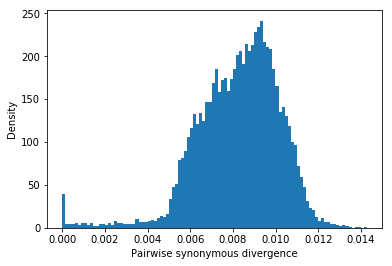

In [7]:
# choose a clade cutoff based on the plot
div_dir = os.path.join(config.analysis_directory, 'pairwise_divergence', 'between_hosts', '%s.csv' % species_name)
div_mat = np.loadtxt(div_dir, delimiter=',')
uptri = np.triu_indices(div_mat.shape[0], 1)
divs = div_mat[uptri]
_ = plt.hist(divs[divs < 0.03], bins=100, density=True)
plt.xlabel('Pairwise synonymous divergence')
plt.ylabel('Density')
# plt.savefig(os.path.join(config.analysis_directory, 'misc', 'B_vulgatus_pairwise.pdf'))

In [8]:
clade_samples = np.nonzero(div_mat[0, :] < 0.03)[0]
clade_mask = div_mat[0, :] < 0.03 # very importantly, use this to keep only the main clade of B vulgatus

In [9]:
%%time
# pile up plot of the core 4D genome
thresholds = [4000, 6000, 8000]
cumu_runs = np.zeros([np.sum(dh.general_mask), 3])
core_gene_cum = np.zeros([len(core_genes), 3])

# for pair in random.sample(clade_pairs, 1000):
rep = 0
while rep < 3000:
    pair = random.sample(clade_samples, 2)
    if div_mat[pair[0], pair[1]] < 0.005: # removing cousin pairs
        continue
    # get the snp data
    snp_vec, coverage_arr = dh.get_snp_vector(pair)
    # get the location in the full array
    snp_to_core = np.nonzero(coverage_arr)[0]
    snp_genome_locs = snp_to_core[np.nonzero(snp_vec)[0]]

    runs = parallel_utils.compute_runs_all_chromosomes(snp_vec, good_chromo[coverage_arr])
    # filter the runs and accumulate
    for i in range(3):
        threshold = thresholds[i]
        event_starts = snp_genome_locs[:-1][runs > threshold]
        event_ends = snp_genome_locs[1:][runs > threshold]    
        for start, end in zip(event_starts, event_ends):
            cumu_runs[start:end, i] += 1
            gene_start = np.nonzero(core_genes == dh.gene_names[dh.general_mask][start])[0][0]
            gene_end = np.nonzero(core_genes == dh.gene_names[dh.general_mask][end])[0][0]
            core_gene_cum[gene_start:gene_end, i] += 1
    rep += 1

CPU times: user 3min 20s, sys: 4.84 s, total: 3min 25s
Wall time: 3min 27s


In [10]:
def count_local_haplotypes(dh, start_idx, end_idx, sample_mask, snp_tol=1):
    hap = dh.snp_arr[start_idx:end_idx, sample_mask]
    covered = dh.covered_arr[start_idx:end_idx, sample_mask]
    # perform (dumb) pairwise comparison
    res = np.zeros((hap.shape[1], hap.shape[1]))
    for i in range(hap.shape[1]):
        for j in range(hap.shape[1]):
            v = hap[:, i] != hap[:, j]
            c = covered[:, i] & covered[:, j]
            res[i, j] = np.sum(v & c)
    G = nx.from_numpy_matrix(res <= 1)
    components = map(list, sorted(nx.connected_components(G), key=len, reverse=True))
    return components

In [11]:
%%time
# computing the sliding window analysis
window_size = 4000
stride = 1000
start = 0
all_fracs = []
import time
t0 = time.time()
while start < dh.snp_arr.shape[0]:
    end = min(dh.snp_arr.shape[0], start + window_size)
    cs = count_local_haplotypes(dh, start, end, clade_mask)
    frac = np.array(map(len, cs)) / float(np.sum(clade_mask))
    all_fracs.append(frac)
    start += stride
    if start % 10000 == 0:
        print("{:.2}% at {:.2} secs".format(100 * float(start) / dh.snp_arr.shape[0], time.time() - t0))

3.5% at 1.5e+01 secs
6.9% at 2.9e+01 secs
1e+01% at 4.4e+01 secs
1.4e+01% at 5.8e+01 secs
1.7e+01% at 7.3e+01 secs
2.1e+01% at 8.7e+01 secs
2.4e+01% at 1e+02 secs
2.8e+01% at 1.2e+02 secs
3.1e+01% at 1.3e+02 secs
3.5e+01% at 1.5e+02 secs
3.8e+01% at 1.6e+02 secs
4.2e+01% at 1.8e+02 secs
4.5e+01% at 1.9e+02 secs
4.9e+01% at 2.1e+02 secs
5.2e+01% at 2.2e+02 secs
5.6e+01% at 2.3e+02 secs
5.9e+01% at 2.5e+02 secs
6.2e+01% at 2.6e+02 secs
6.6e+01% at 2.8e+02 secs
6.9e+01% at 2.9e+02 secs
7.3e+01% at 3.1e+02 secs
7.6e+01% at 3.2e+02 secs
8e+01% at 3.4e+02 secs
8.3e+01% at 3.5e+02 secs
8.7e+01% at 3.7e+02 secs
9e+01% at 3.8e+02 secs
9.4e+01% at 3.9e+02 secs
9.7e+01% at 4.1e+02 secs
CPU times: user 6min 54s, sys: 3.05 s, total: 6min 57s
Wall time: 7min 1s


In [12]:
import pandas as pd
df = pd.DataFrame()
df['Start'] = np.arange(0, dh.snp_arr.shape[0], stride)
df['End'] = np.minimum(df['Start'] + window_size, dh.snp_arr.shape[0])
df['MaxFrac'] = map(max, all_fracs)
df['Heterozygosity'] = map(lambda x: np.sum(x*x), all_fracs)
df['MaxFrac^2'] = df['MaxFrac'] ** 2
df['H12'] = map(lambda x: np.sum(x*x) + 2*x[0]*x[1] if len(x) > 1 else x[0]**2, all_fracs)
df['H2'] = map(lambda x: np.sum(x*x) - x[0]**2, all_fracs)

In [13]:
# for snp density plot
has_snp = np.sum((dh.snp_arr & dh.covered_arr)[:, clade_mask], axis=1) > 0

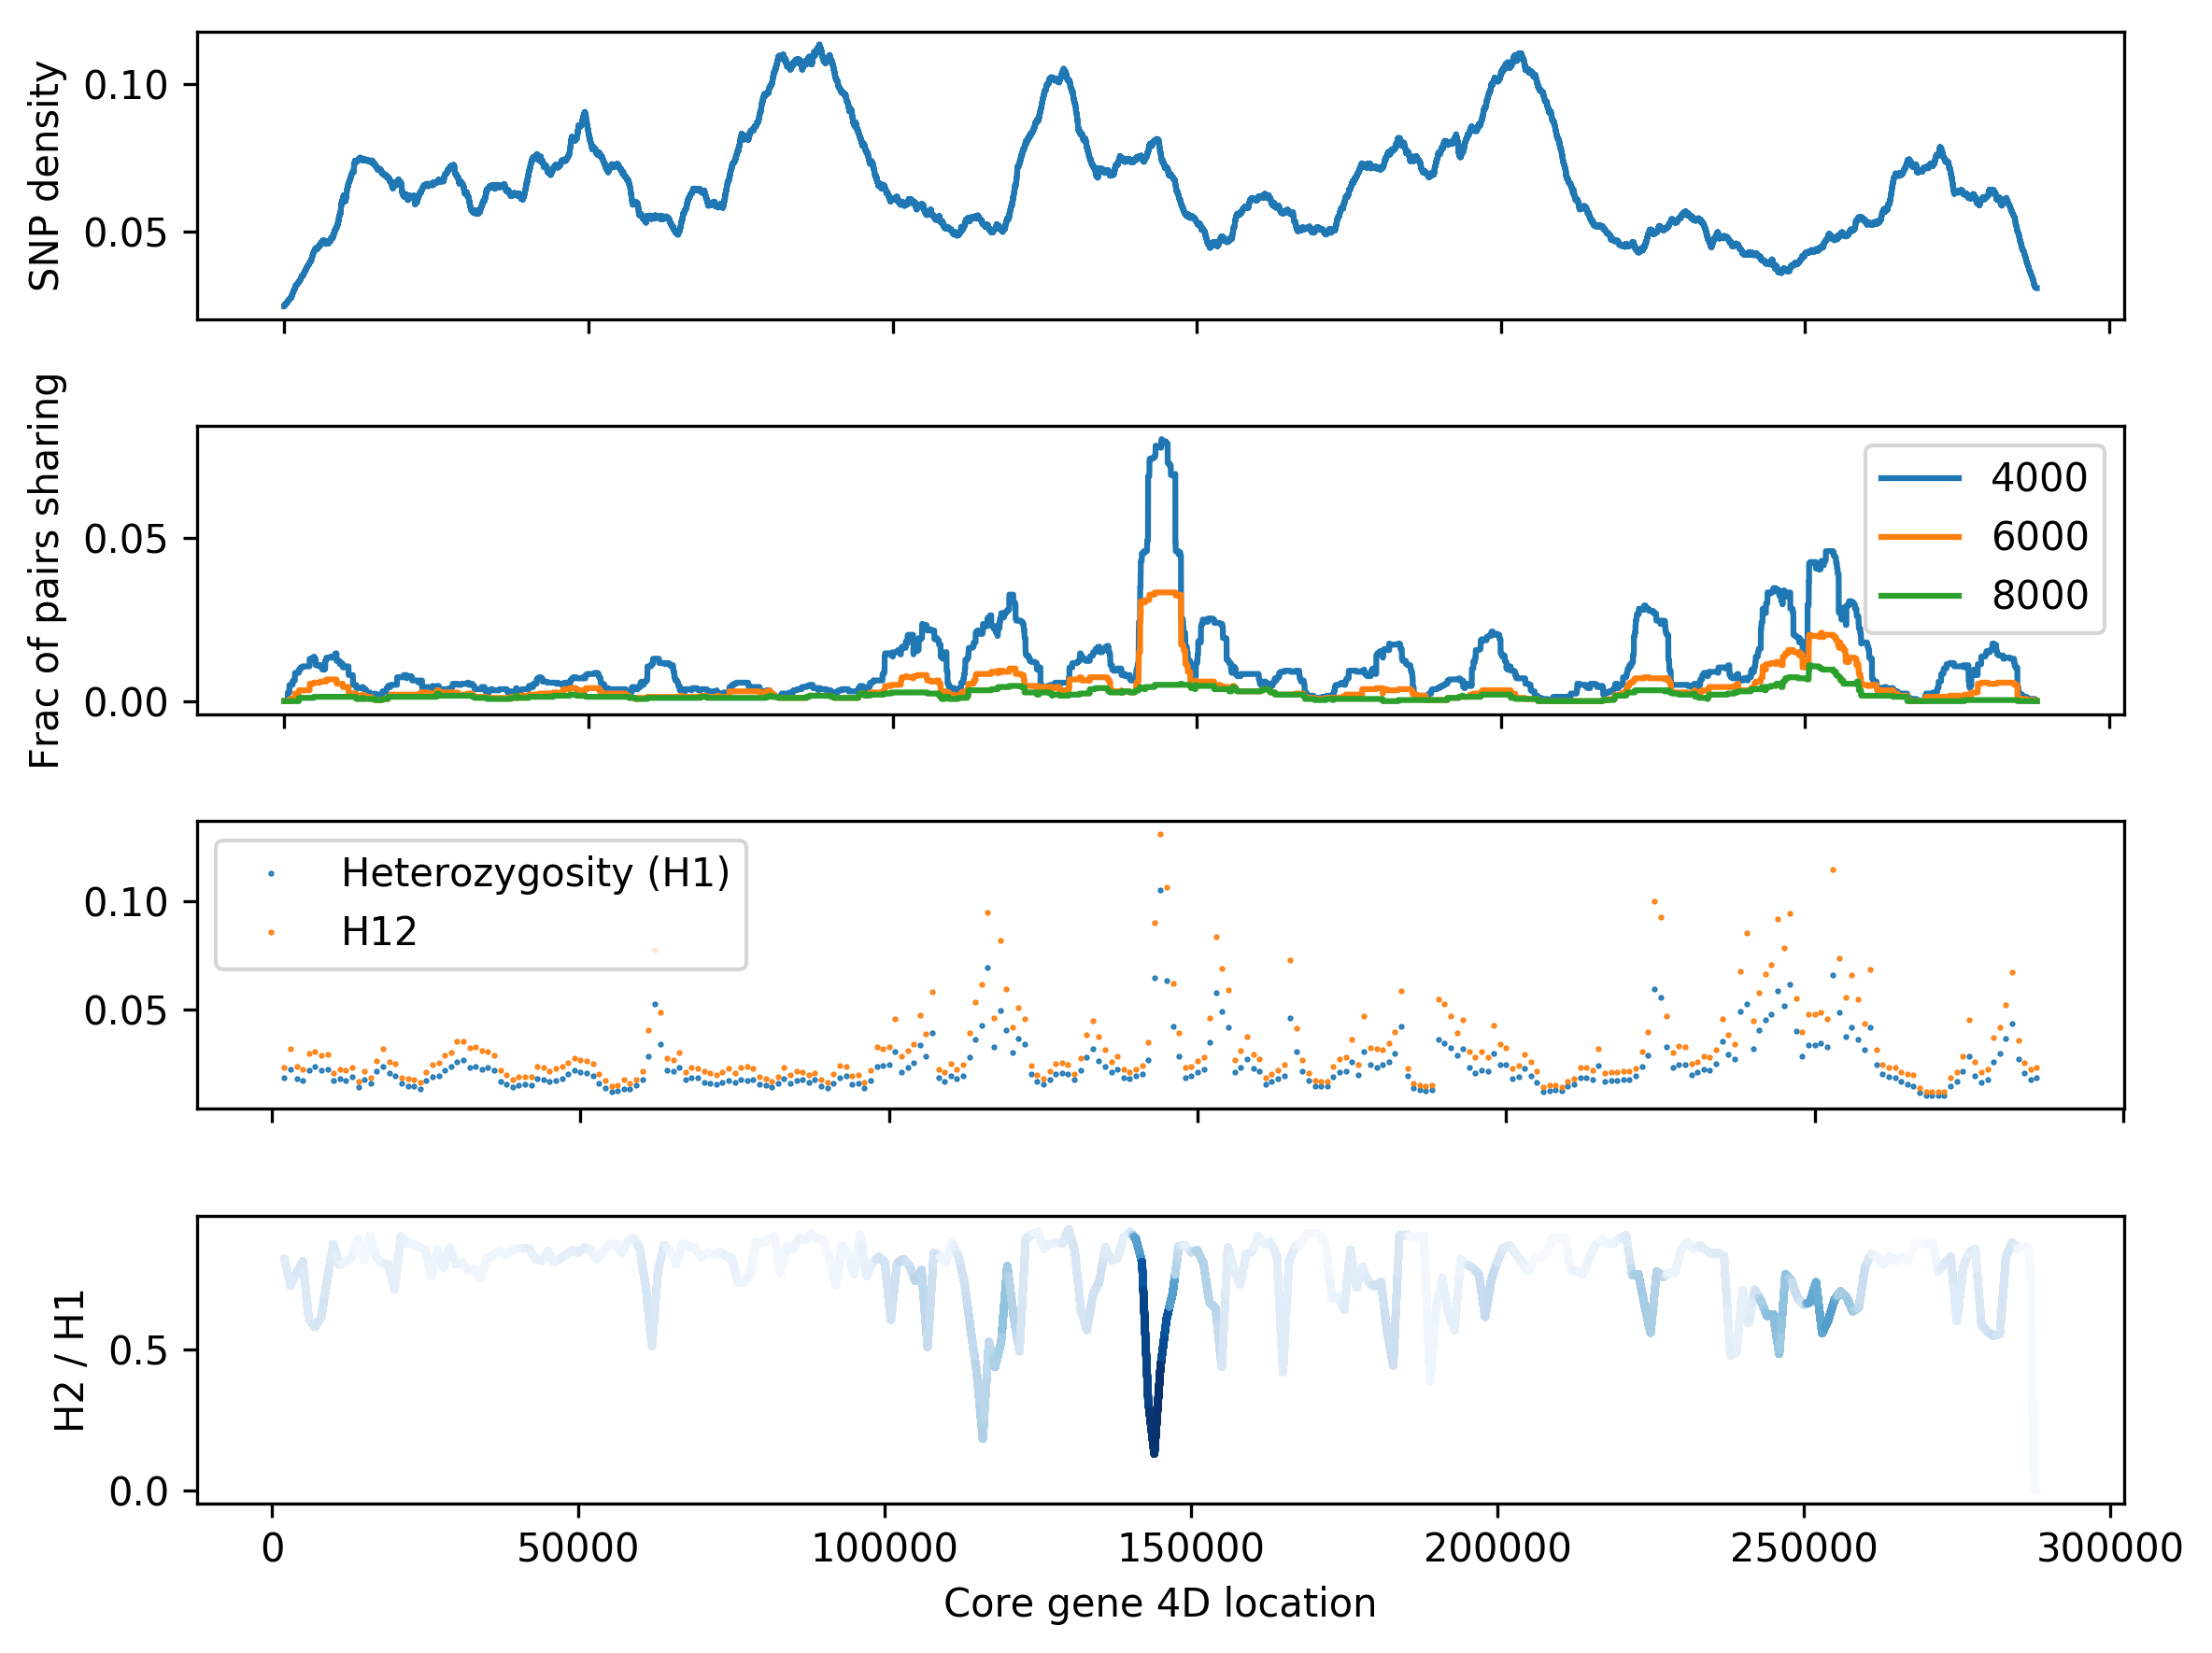

In [15]:
from matplotlib import cm # for color map

fig, axes = plt.subplots(4, 1, figsize=(8, 6), dpi=300)
snp_window = 10000
axes[0].plot(np.convolve(has_snp, np.ones(snp_window)/snp_window, mode='Same'))
for i in range(3):
    axes[1].plot(cumu_runs[:, i] / 3000, label=thresholds[i])

from scipy.interpolate import interp1d
y = np.array(df['H2'] / df['Heterozygosity'])
x = np.array((df['Start'] + df['End']) / 2).astype(int)
f = interp1d(x, y)
xnew = np.arange(min(x), max(x))
c_val = cumu_runs[xnew, 0]
axes[3].scatter(xnew, f(xnew), s=1, c=cm.Blues(np.abs(c_val / max(c_val))), label='H2/H1')

axes[2].plot(x[:-4], df['Heterozygosity'][:-4], '.', markersize=1, label='Heterozygosity (H1)')
axes[2].plot(x[:-4], df['H12'][:-4], '.', markersize=1, label='H12')

for i in range(3):
    axes[i].set_xticklabels([])
axes[1].legend()
axes[2].legend()
axes[0].set_ylabel('SNP density')
axes[1].set_ylabel('Frac of pairs sharing')
axes[3].set_ylabel('H2 / H1')
axes[3].set_xlabel('Core gene 4D location')
plt.tight_layout()

(0.024324733262723292, 0.011989376071705202)


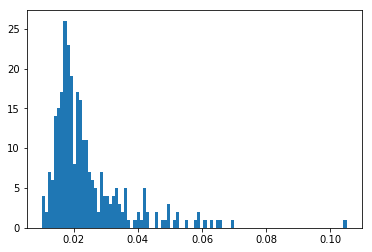

In [20]:
_ = plt.hist(df['Heterozygosity'][:-4], bins=100)
print(np.mean(df['Heterozygosity'][:-4]), np.std(df['Heterozygosity'][:-4]))

In [23]:
np.sum(has_snp) / float(len(has_snp))

0.066259602400730352

In [28]:
np.sum(has_snp) / float(len(has_snp)) / np.sum(np.reciprocal(np.arange(281, dtype=float)+1))

0.010657211981426331

In [30]:
np.mean(divs[divs < 0.03])

0.0082516409105293891